In [2]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.6/150.0 MB 13.7 MB/s eta 0:00:11
   - -------------------------------------- 7.1/150.0 MB 17.5 MB/s eta 0:00:09
   -- ------------------------------------- 10.7/150.0 MB 17.7 MB/s eta 0:00:08
   --- ------------------------------------ 14.9/150.0 MB 18.1 MB/s eta 0:00:08
   ---- ----------------------------------- 18.6/150.0 MB 18.1 MB/s eta 0:00:08
   ------ --------------------------------- 22.5/150.0 MB 18.1 MB/s eta 0:00:08
   ------- -------------------------------- 26.5/150.0 MB 18.0 MB/s eta 0:00:07
   -------- ------------------------------- 30.1/150.0 MB 18.2 MB/s eta 0:00:07
   --------- ------------------------------ 34.1/150.0 MB 18.2 MB/s eta 0:00:07
   ---------- ----------------------------- 38.0/150.0 MB 18.2 MB/s eta 0:00:07
   ----------- ---------------------------- 41.9/150.

In [13]:
# Task 1: Model Development and Training

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Dataset_Uber Traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d/%m/%y %H:%M")
df['Hour'] = df['DateTime'].dt.hour
df['Weekday'] = df['DateTime'].dt.weekday
df['Month'] = df['DateTime'].dt.month


In [15]:
# Simulate weather data
np.random.seed(42)
weather_data = pd.DataFrame({
    'DateTime': df['DateTime'].unique(),
    'Temperature': np.random.uniform(15, 35, size=df['DateTime'].nunique()),
    'Precipitation': np.random.choice([0, 0.1, 0.5, 1.0, 2.0], size=df['DateTime'].nunique(), p=[0.7, 0.1, 0.1, 0.05, 0.05]),
    'Humidity': np.random.uniform(40, 90, size=df['DateTime'].nunique()),
    'WindSpeed': np.random.uniform(0, 30, size=df['DateTime'].nunique())
})
df = df.merge(weather_data, on='DateTime', how='left')

# Simulate event/holiday flag
event_days = pd.to_datetime(["2015-11-14", "2015-12-25", "2016-01-01", "2016-08-15", "2017-01-26"])
df['Is_Holiday'] = df['DateTime'].dt.date.isin(event_days.date).astype(int)

# Time-based split
df_sorted = df.sort_values("DateTime")
cutoff = df_sorted["DateTime"].max() - pd.DateOffset(months=2)
train_data = df_sorted[df_sorted["DateTime"] <= cutoff]
test_data = df_sorted[df_sorted["DateTime"] > cutoff]

In [16]:

features = ['Junction', 'Hour', 'Weekday', 'Month', 'Temperature', 'Precipitation', 'Humidity', 'WindSpeed', 'Is_Holiday']
X_train = train_data[features]
y_train = train_data['Vehicles']
X_test = test_data[features]
y_test = test_data['Vehicles']

# Train Gradient Boosting model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [17]:
# Task 2: Model Evaluation & Cross Validation

# Evaluation metrics

In [18]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")


MAE: 14.27, RMSE: 20.90, R²: 0.472


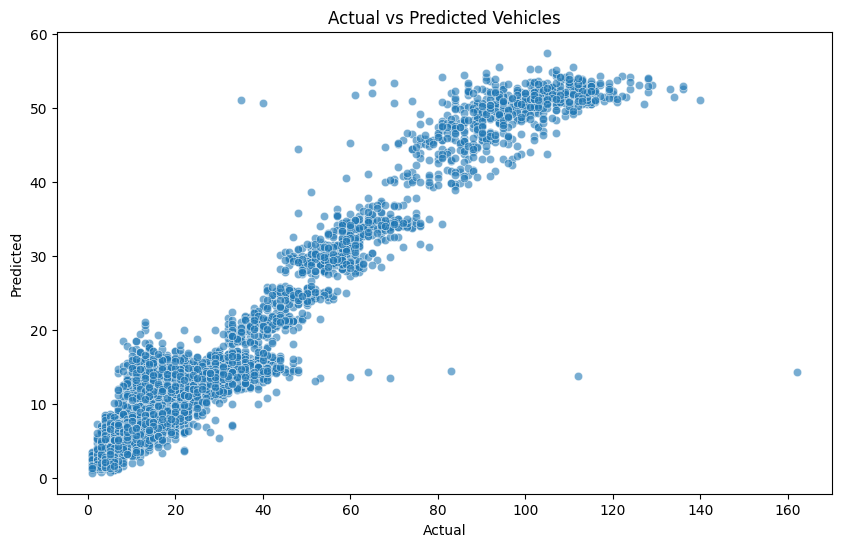

In [19]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Vehicles")
plt.show()